In [ ]:
!pip install pandas numpy matplotlib seaborn nltk wordcloud scikit-learn imbalanced-learn gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')  # Tokenizer models
nltk.download('wordnet')  # Lemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.combine import SMOTETomek  # For handling imbalance
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
tweet_df = pd.read_csv('/content/train.csv')

In [ ]:
tweet_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [ ]:
tweet_df = tweet_df.drop_duplicates('tweet')


In [ ]:
def data_processing(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"https\S+|www\S+http\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet_tokens = word_tokenize(tweet)
    filtered_tweets = [w for w in tweet_tokens if w not in stopwords.words('english')]
    return " ".join(filtered_tweets)

tweet_df['tweet'] = tweet_df['tweet'].apply(data_processing)


In [ ]:
lemmatizer = WordNetLemmatizer()
tweet_df['tweet'] = tweet_df['tweet'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))


In [ ]:

print("Class distribution before balancing:")
print(tweet_df['label'].value_counts())

Class distribution before balancing:
label
0    27517
1     2013
Name: count, dtype: int64


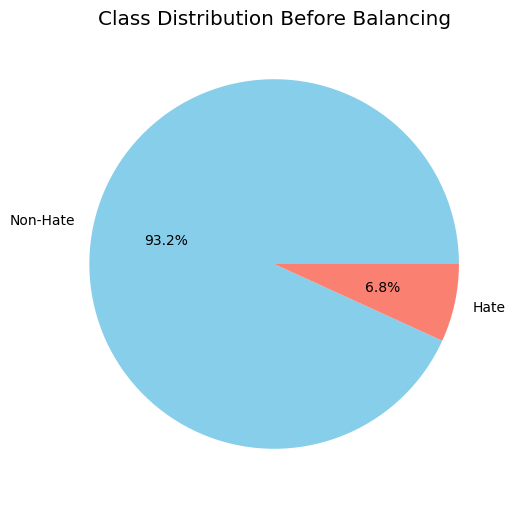

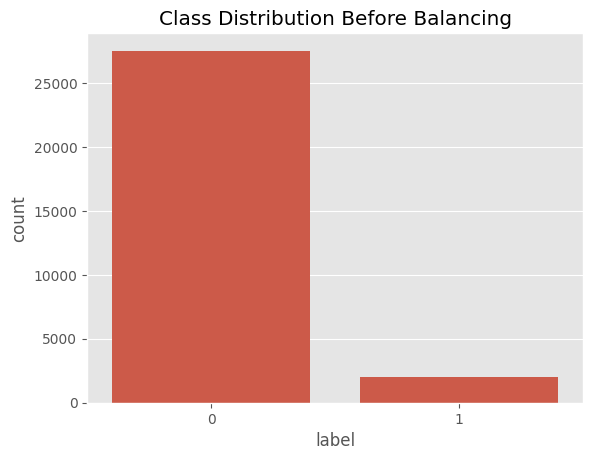

In [ ]:
plt.figure(figsize=(6, 6))
tweet_df['label'].value_counts().plot.pie(autopct='%1.1f%%', labels=["Non-Hate", "Hate"], colors=["skyblue", "salmon"])
plt.title("Class Distribution Before Balancing")
plt.ylabel("")
plt.show()

sns.countplot(x='label', data=tweet_df)
plt.title('Class Distribution Before Balancing')
plt.show()

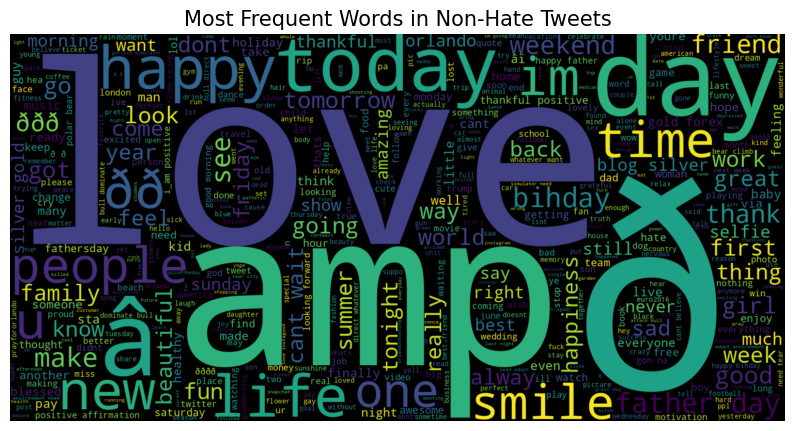

In [ ]:
non_hate_tweets = tweet_df[tweet_df.label == 0]
text = ' '.join(non_hate_tweets['tweet'])
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Non-Hate Tweets', fontsize=15)
plt.show()

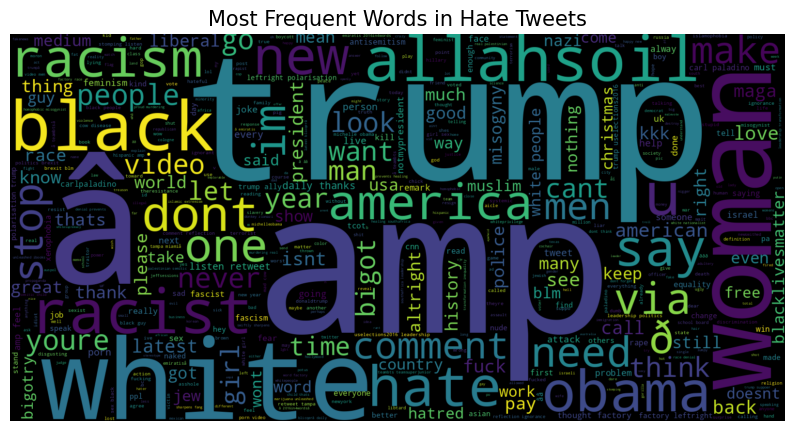

In [ ]:
hate_tweets = tweet_df[tweet_df.label == 1]
text = ' '.join(hate_tweets['tweet'])
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Hate Tweets', fontsize=15)
plt.show()

In [ ]:
vect = TfidfVectorizer(ngram_range=(1, 3)).fit(tweet_df['tweet'])
X = vect.transform(tweet_df['tweet'])
Y = tweet_df['label']



In [ ]:
smote_tomek = SMOTETomek(random_state=42)
X_resampled, Y_resampled = smote_tomek.fit_resample(X, Y)


In [ ]:

unique, counts = np.unique(Y_resampled, return_counts=True)
print(f"Class distribution after SMOTETomek: {dict(zip(unique, counts))}")


Class distribution after SMOTETomek: {0: 27517, 1: 27517}


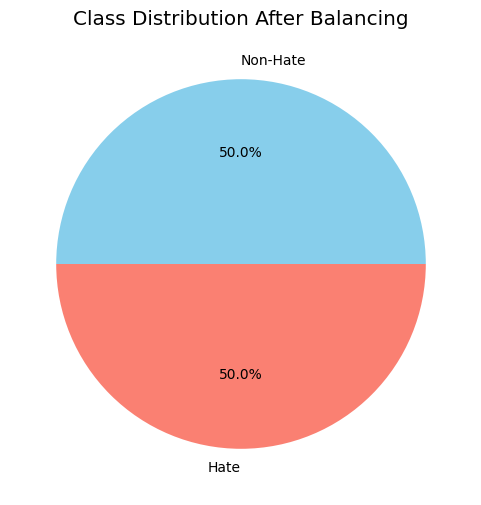

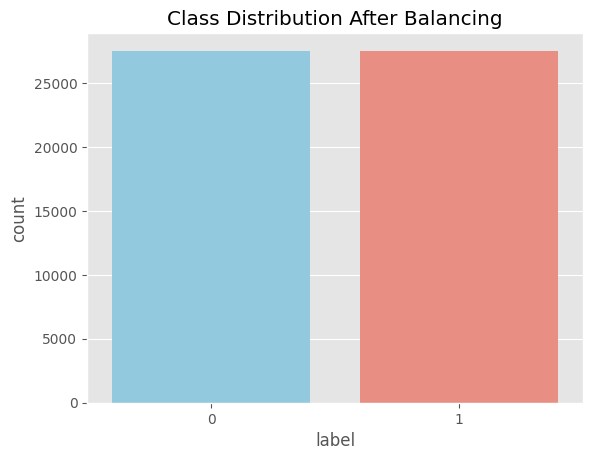

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=["Non-Hate", "Hate"], autopct='%1.1f%%', colors=["skyblue", "salmon"])
plt.title("Class Distribution After Balancing")
plt.show()

sns.countplot(x=Y_resampled, palette=["skyblue", "salmon"])
plt.title('Class Distribution After Balancing')
plt.show()


In [ ]:

x_train, x_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42)

In [ ]:

logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:

y_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {logreg_acc * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 96.37%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      5481
           1       0.97      0.96      0.96      5526

    accuracy                           0.96     11007
   macro avg       0.96      0.96      0.96     11007
weighted avg       0.96      0.96      0.96     11007



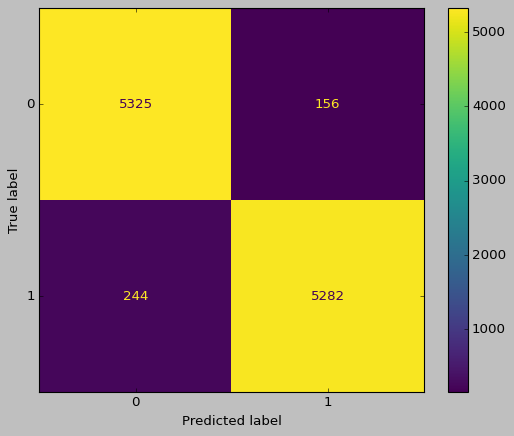

In [ ]:
style.use('classic')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()
plt.show()

In [ ]:
import pickle
with open('hate_speech_model.pkl', 'wb') as model_file:
    pickle.dump(logreg, model_file)
with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vect, vectorizer_file)

print("Model and vectorizer saved!")

Model and vectorizer saved!


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
import pickle

def predict_hate_speech(tweet):
    # Load the model and vectorizer
    with open('hate_speech_model.pkl', 'rb') as model_file:
        model = pickle.load(model_file)
    with open('vectorizer.pkl', 'rb') as vectorizer_file:
        vectorizer = pickle.load(vectorizer_file)

    # Preprocess the input tweet
    tweet = data_processing(tweet)
    tweet_vect = vectorizer.transform([tweet])

    # Make a prediction
    prediction = model.predict(tweet_vect)
    return "💔 Hate Speech" if prediction == 1 else "💖 Non-Hate Speech"

# Custom styling and enhanced interface
iface = gr.Interface(
    fn=predict_hate_speech,
    inputs=gr.Textbox(
        lines=3,
        placeholder="Type your tweet here...",
        label="📝 Enter Tweet",
    ),
    outputs=gr.Label(label="🔍 Prediction"),
    title="🌟 Hate Speech Detection System 🌟",
    description=(
        "Welcome to the Hate Speech Detection System! 🌐\n\n"
        "This AI-powered tool analyzes tweets to determine if they contain hate speech. "
        "Simply type or paste a tweet in the box, and the system will instantly classify it. "
        "Built with 💡 machine learning and ❤️ for a better online world.\n\n"
        "---\n"
        "How to use:\n"
        "- Enter a tweet in the text box below.\n"
        "- View the prediction instantly (💔 for Hate Speech, 💖 for Non-Hate Speech).\n"
        "---"
    ),
    examples=[
        ["I love the world!"],
        ["I hate you!"],
        ["You are amazing!"],

    ],
    theme="compact",
    live=True
)

iface.launch()